# 쿼리 재작성 모듈 추가

**절차**

1. Naive RAG 수행
2. 검색된 문서에 대한 관련성 체크(Groundedness Check)
3. Web Search
4. (이번 튜토리얼) Query Rewrite

**참고**

- 이전 튜토리얼에서 확장된 내용이므로, 겹치는 부분이 있을 수 있습니다. 부족한 설명은 이전 튜토리얼을 참고해주세요.

![langgraph-query-rewrite](assets/langgraph-query-rewrite.png)

## 환경 설정

In [1]:
# !pip install -U langchain-teddynote

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Structures


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

이번에는 상태(State)에 관련성(relevance) 체크 결과를 추가합니다.

**참고**

- 이번에는 `question` 을 list 형식으로 정의합니다. 재작성된 Query 를 추가로 저장하기 위함입니다.

In [4]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[List[str], add_messages]  # 질문(누적되는 list)
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [5]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return {"relevance": response.score}


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=6,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context": search_result}

## Query Rewrite 노드 추가

Query 를 재작성하는 프롬프트를 활용하여 기존의 질문을 재작성합니다.

In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite 프롬프트 정의
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

생성한 `question_rewriter` 를 활용하여 질문을 재작성합니다.

In [7]:
# 질문 재작성
question = "앤스로픽에 투자한 미국기업"

question_rewriter.invoke({"question": question})

'앤스로픽에 투자한 미국 기업은 어떤 곳들이 있나요?'

In [8]:
# Query Rewrite 노드
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return {"question": question_rewritten}

## Edges

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [9]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

# Query Rewrite 노드 추가
workflow.add_node("query_rewrite", query_rewrite)

# 엣지 추가
workflow.add_edge("query_rewrite", "retrieve")  # 질문 재작성 -> 검색
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "web_search",  # 관련성이 없으면 다시 검색합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("query_rewrite")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

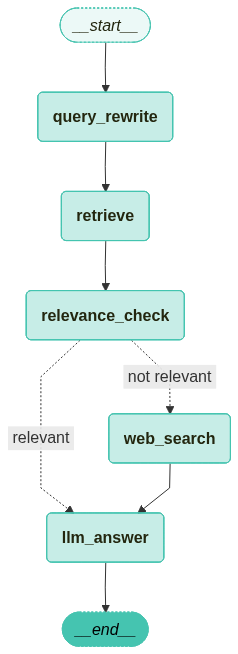

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

검색 결과의 `relevance_check` 가 실패할 경우, 검색을 수행하여 웹 검색 결과를 제공합니다.

In [11]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="앤스로픽 투자 금액")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
앤스로픽에 대한 투자 금액은 얼마인가요?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 3

In [12]:
# 그래프 실행
stream_graph(app, inputs, config) #["query_rewrite", "llm_answer"]


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
앤스로픽에 대한 투자 금액은 얼마인가요?
🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 계획입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [13]:
# 최종 출력 확인
outputs = app.get_state(config).values

print(f'Original Question: {outputs["question"][0].content}')
print(f'Rewritten Question: {outputs["question"][-1].content}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Original Question: 앤스로픽 투자 금액
Rewritten Question: 앤스로픽에 대한 투자 금액은 얼마인가요?
Answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 계획입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)
